What I plan to do with this notebook:

- Explain in accessible terms normalizing flows

- Implement a basic version of normalizing flows based on coupling functions

- Illustrate it on toy data

### Introduction

Some context

Describe the problem

Introduce normalizing flows as a solution

### Normalizing flows

Describe the general formulation

Show what we can do: density estimation, and sampling

Describe what is required, what properties are desirable (e.g. flexibility, and tractable Jacobian).

### Implementation

Describe coupling functions and implement them

Train on a toy dataset from a bi-modal Gaussian distribution

Train on CIFAR-10?



# Transforming distributions with Normalizing Flows

Probability distributions are all over machine learning. They can determine the structure of a model for supervised learning (are we doing linear regression over a Gaussian random variable, or is it categorical?); and they can serve as goals in unsupervised learning, to train generative models that we can use to evaluate the probability density for any observation, or to generate novel samples.

Normalizing Flows are a particular mechanism for dealing with probability distributions, that continues to receive increased attention from the machine learning community. Just a few weeks ago, a <a href="https://invertibleworkshop.github.io/">whole workshop</a> was devoted to them (and some related methods) at the ICML 2020 conference. So what are Normalizing Flows and why should we care about them?

In this post I will attempt to answer this question, covering

- An introductory description of NFs and their applications
- A basic implementation using PyTorch
- The results after training a model for density estimation with NFs



Normalizing flows are based on a fundamental result from probability theory. Assume $\textbf{u}$ is a vector in a d-dimensional space $\mathbb{R}^d$, obtained by sampling a random variable with probability density $p_u(\mathbf{u})$. A normalizing flow is a differentiable transformation $T$ with inverse $T^{-1}$, such that if we pass $\mathbf{u}$ through $T$, we get another vector $T(\mathbf{u}) = \mathbf{x}$ in $\mathbb{R}^d$. Since $\mathbf{u}$ is a sample from a random variable, it follows that $\mathbf{x}$ is also a sample from another random variable. It turns out that the density of the transformed random variable can be computed as

$$
p_x(\mathbf{x}) = p_u(\mathbf{u})\left\vert \text{det } \mathbf{J}_T(\mathbf{u}) \right\vert^{-1}\tag{1}
$$
In this formula, $\mathbf{J}_T(\mathbf{u})$ is the Jacobian of the transformation $T$ with respect to $\mathbf{u}$. This is a $d\times d$ matrix that contains all partial derivatives of the elements in $\mathbf{x}$ with respect to all elements in $\mathbf{u}$:
$$
\mathbf{J}_T(\mathbf{u}) =
\begin{bmatrix}
\frac{\partial T_1}{\partial u_1} & \dots & \frac{\partial T_1}{\partial u_d} \\
\vdots & \ddots & \vdots \\
\frac{\partial T_d}{\partial u_1} & \dots & \frac{\partial T_d}{\partial u_d}
\end{bmatrix}
$$
The above fact is particularly interesting if $p_u(\mathbf{u})$ is a distribution for which we can easily evaluate the density (such as a Gaussian distribution), and $T$ is a flexible transformation that can potentially produce a more complicated density $p_x(\mathbf{x})$: 



<img src="flow.png" style="zoom:37%;" />



What is interesting is that we don't need explicit access to the transformed density to evaluate it for any $\mathbf{x}$. Instead, following eq. 1, we can transform $\mathbf{x}$ back to $T^{-1}(\mathbf{x}) = \mathbf{u}$, evaluate the density with $p_u(\mathbf{u})$, and multiply it by the Jacobian of the inverse:
$$
\begin{align}
p_x(\mathbf{x}) &= p_u(\mathbf{u})\left\vert \text{det } \mathbf{J}_T(\mathbf{u}) \right\vert^{-1} \\
&= p_u(T^{-1}(\mathbf{x}))\left\vert \text{det } \mathbf{J}_{T^{-1}}(\mathbf{x}) \right\vert
\end{align}
$$
In fact, we can formulate $T$ as a composition of $K$ differentiable, invertible transformations $T = T_K \circ\dots T_1$, to obtain more flexible a more flexible flow, and the density is simply modified with products of determinants:
$$
p_x(\mathbf{x}) = p_u(T^{-1}(\mathbf{x}))\prod_{k = 1}^K\left\vert \text{det } \mathbf{J}_{T_k^{-1}}(\mathbf{x}) \right\vert
$$


This <a href="https://arxiv.org/abs/1410.8516" target="_blank">nice</a> property has been exploited for density estimation in high dimensional spaces with complicated distributions, such as images. By mapping them back to a simple distribution using a normalizing flow, we can optimize the parameters $\theta$ of a model by maximizing its log-likelihood $\log p_x(\mathbf{x};\theta)$. In particular, for a dataset with $N$ observations, we want to maximize
$$
\log \prod_{i=1}^N p(\mathbf{x}^{(i)};\theta) = \sum_{i = 1}^N\log p_u(T^{-1}(\mathbf{x}^{(i)});\theta) + \sum_{k=1}^K\log\vert\text{det }\mathbf{J}_{T_k^{-1}}(\mathbf{x}^{(i)}; \theta)\vert\tag{2}
$$
Note that the parameters of the model can be the parameters of the base density $p_u(\mathbf{u})$ (such as the mean and covariance), as well as any parameters involved in the transformation $T$.

Once we have trained a model with normalizing flows, we have a generative model that we can use to

- Evaluate the density $p_x(\mathbf{x})$ for a new observation
- Generate samples that look like observations used for training, by sampling $\mathbf{u}\sim p_u(\mathbf{u})$  and passing it through the flow to get $\mathbf{x} = T(\mathbf{u})$.



There is one last caveat to highlight before we can actually use normalizing flows with neural networks: the determinant of the Jacobian. In general, computing the determinant of a $d\times d$ requires a computation proportional to $d^3$, which can become unfeasible for large $d$. There is a special case, however. For a *triangular* matrix, the determinant reduces to the product of its elements in the diagonal. This then turns the amount of computation proportional to $d$. The reduction from cubic to linear complexity is a key motivator for the use of normalizing flows in machine learning.



## Implementing tractable flows

One way to implement a normalizing flow that results in a triangular Jacobian is to use *coupling layers*, introduced by <a href="https://arxiv.org/abs/1410.8516" target="_blank">Dihn et al. (2015)</a>. A coupling layer leaves the first $d$ elements unchanged, and the rest of the elements are linearly transformed with a (possibly nonlinear) function of the first $d$ elements. More formally, if $\mathbf{z}$ is the input vector and by $\mathbf{z}_{1:d}$ we denote a slice of the first $d$ elements, a coupling layer implements the following equations to produce the output vector $\mathbf{z}'$:
$$
\begin{align}
\mathbf{z}'_{1:d} &= \mathbf{z}_{1:d} \\
\mathbf{z}'_{d+1:D} &= \mathbf{z}_{d+1:D}\odot\exp(s(\mathbf{z}_{1:d})) + t(\mathbf{z}_{1:d})
\end{align}
$$
where $\odot$ denotes element-wise multiplication, and $s$ and $t$ are scaling and translation functions that can be implemented with neural networks.

We may now ask two questions: 1) What is the inverse of this transformation? We can easily invert the two equations above to obtain
$$
\begin{align}
\mathbf{z}_{1:d} &= \mathbf{z}_{1:d}' \\
\mathbf{z}_{d+1:D} &= (\mathbf{z}_{d+1:D}' - t(\mathbf{z}_{1:d}'))\odot\exp(-s(\mathbf{z}_{1:d}'))
\end{align}
$$

2) What is the determinant of the Jacobian? Since the first $d$ elements of the output are the same as the input, there will be a $d\times d$ block in the Jacobian containing an identity matrix. The remaining elements only depend on the first $d$, and themselves, so the Jacobian is triangular with the following structure:
$$
\mathbf{J}(\mathbf{z}) = \begin{bmatrix}
\mathbf{I} & \mathbf{0} \\
\mathbf{A} & \text{diag}(\exp(s(\mathbf{z}_{1:d})))
\end{bmatrix}
$$
In this case, the determinant reduces to the products of the diagonal in the matrix $\text{diag}(\exp(s(\mathbf{z}_{1:d})))$, and simplifies further when computing the logarithm:
$$
\begin{align}
\log\vert\text{det }\mathbf{J}(\mathbf{z})\vert &= \log\prod_{i=1}^d \exp(s(\mathbf{z}_{1:d})_i) \\
&= \sum_{i=1}^d s(\mathbf{z}_{1:d})_i
\end{align}
$$

Lastly, for the inverse of the transformation we have
$$
\log\vert\det\mathbf{J}(\mathbf{z})\vert^{-1} = -\sum_{i=1}^d s(\mathbf{z}_{1:d})_i
$$
We now have all the ingredients to implement a coupling layer. To select only some parts of the input we will use a binary tensor to mask values, and for the scaling and translation functions we will use a 2-layer feed-forward neural network, sharing parameters for both functions.

In [1]:
import torch.nn as nn

class Coupling(nn.Module):
    def __init__(self, dim, num_hidden, mask):
        super().__init__()
        
        # The output is of size dim * 2, that we later split in two
        # for the scale and translation values
        self.nn = torch.nn.Sequential(nn.Linear(dim, num_hidden),
                                      nn.ReLU(),
                                      nn.Linear(num_hidden, num_hidden),
                                      nn.ReLU(),
                                      nn.Linear(num_hidden, dim * 2))

        # Initialize the coupling to implement the identity transformation
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
        
        self.register_buffer('mask', mask)

    def forward(self, z, log_det, inverse=False):
        mask = self.mask
        neg_mask = 1 - mask
        
        # Compute scale and translation for relevant inputs
        s_t = self.nn(z * mask)
        s, t = torch.chunk(s_t, chunks=2, dim=1)

        if not inverse:
            z = mask * z + neg_mask * (z * torch.exp(s) + t)
            log_det = log_det + (neg_mask * s).sum(dim=1)
        else:
            z = mask * z + neg_mask * (z - t) * torch.exp(-s)
            log_det = log_det - (neg_mask * s).sum(dim=1)

        return z, log_det

Now that we have defined a module for a coupling layer, we can use composition of coupling layers to build a normalizing flow.

We will use the `forward` method of the flow to compute the density of an observation $\mathbf{x}$ following equation 2. Additionally, we will define a `sample` method that takes a sample from the base distribution $p_u(\mathbf{u})$ and passes it through the flow in the inverse direction to obtain what would be a sample from the target distribution. These two methods traverse the flow in one or another direction, which we define in the `transform` method.

There are two practicalities yet to define at this point. First, even though we defined the coupling layer as transforming the input from index $d+1$ to $D$, in practice it's better to compose flows where we alternate the specific dimensions that are transformed, and those that are not. Here we use binary masks of the form `[1, 0, 1, 0, ...]`. For the following coupling layer, we use the negated mask `[0, 1, 0, 1, ...]`. This gives a chance to the flow for transforming all dimensions in the input.

The second practicality has to do with the base distribution $p_u(\mathbf{u})$. If we use a standard Gaussian distribution, the log-probability is
$$
\begin{align}
\log\mathcal{N}(\mathbf{u}\vert\mathbf{0}, \mathbf{I}) &= \log\left(\frac{1}{(2\pi)^{D/2}}\exp\left\lbrace-\frac{1}{2}\mathbf{u}^\top\mathbf{u}\right\rbrace\right) \\
&= -\frac{D}{2}\log(2\pi) - \frac{1}{2}\mathbf{u}^\top\mathbf{u}
\end{align}
$$

We now have all the ingredients to implement the Normalizing Flow:

In [2]:
import torch
import numpy as np

class NormalizingFlow(nn.Module):
    def __init__(self, dim, num_flows, num_hidden):
        super().__init__()
        
        # Create mask with alternating pattern
        mask = torch.tensor([1.0, 0.0]).repeat((dim // 2) + 1)
        # Crop to dimension of input
        mask = mask[:dim].unsqueeze(0)
        
        self.layers = nn.ModuleList()
        for i in range(num_flows // 2):
            self.layers.append(Coupling(dim, num_hidden, mask))
            self.layers.append(Coupling(dim, num_hidden, 1 - mask))
        
        # The initial value of the log-determinant is 0
        self.register_buffer('init_log_det', torch.zeros(1))
        self.dim = dim
        self.mask = mask
                    
    def transform(self, z, inverse=False):
        log_det = self.init_log_det
        if not inverse:
            for layer in self.layers:
                z, log_det = layer(z, log_det)                
        else:
            for layer in reversed(self.layers):
                z, log_det = layer(z, log_det, inverse=True)
        
        return z, log_det
                
    def forward(self, x):
        u, log_det = self.transform(x)
        log_pu = -0.5 * self.dim * (np.log(2.0 * np.pi) + (u ** 2).sum(dim=1))
        # Equation 2
        log_px = log_pu + log_det
        
        # Return the negative for minimization
        return -log_px
    
    def sample(self, num_samples):
        # Sample from base (Gaussian) distribution
        # and transform with flow
        u = torch.randn((num_samples, self.dim))        
        x, _ = self.transform(u, inverse=True)
        return x

## Training the model

For visualization purposes, we will train a model for a very simple case where the data lies in a 2-dimensional space. Followin our implementation, the base distribution is a standard Gaussian:

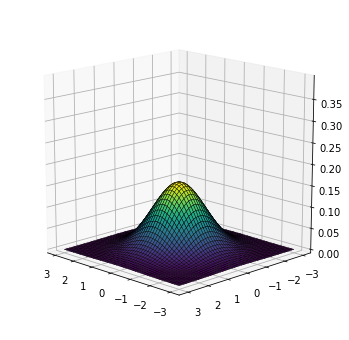

In [3]:
from utils import base, target, plot_density

plot_density(base)

And the target is a bimodal Gaussian distribution:

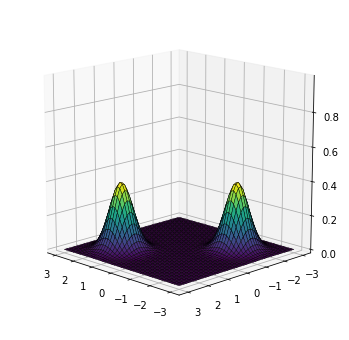

In [4]:
plot_density(target)

In [5]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(target.sample(2000))
loader = DataLoader(dataset, batch_size=64)

In [6]:
from torch.optim import Adam

flow = NormalizingFlow(dim=2, num_flows=4, num_hidden=8)
optimizer = Adam(flow.parameters())

In [7]:
from tqdm.notebook import tqdm

num_epochs = 100
num_iters = num_epochs * len(loader)
progress = tqdm(total=num_iters)
losses = np.zeros(num_epochs)

for epoch in range(1, num_epochs + 1):
    mean_loss = 0.0
    for data in loader:
        loss = flow(data[0]).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        desc = f'Epoch {epoch}/{num_epochs} - loss: {loss.item():.3f}'
        progress.set_description_str(desc)
        progress.update()
        
        mean_loss += loss.item()
        
    losses[epoch - 1] = mean_loss / len(loader)
        
progress.close()

Text(0, 0.5, 'Negative log-likelihood')

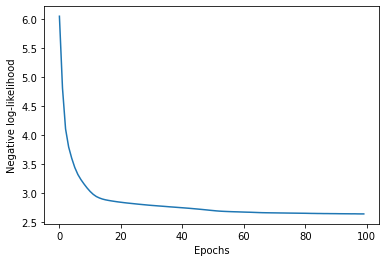

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Negative log-likelihood')

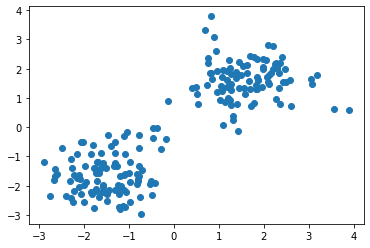

In [9]:
samples = flow.sample(200).detach().cpu()
plt.scatter(samples[:, 0], samples[:, 1])

In [10]:
from utils import make_mesh

In [11]:
x1, x2, x = make_mesh()

In [12]:
x.shape

torch.Size([50, 50, 2])

In [13]:
x.reshape(-1, 2).shape

torch.Size([2500, 2])

In [14]:
log_px = -flow(x.reshape(-1, 2))
log_px = log_px.reshape(x.shape[:2]).detach()
px = log_px.exp()

In [15]:
from utils import plot_surface

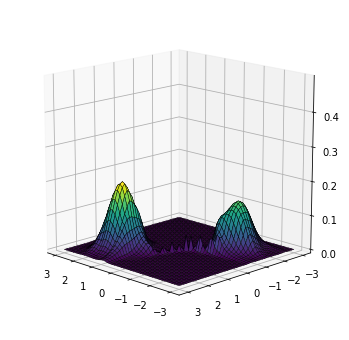

In [16]:
plot_surface(x1, x2, px)

In [17]:
plt.savefig('test.png')

<Figure size 432x288 with 0 Axes>